In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tarp import get_tarp_coverage

# Path wherever you have the data stored
base_path = "./lens_exp"

# Load everything
obs = torch.load(f"{base_path}/observations.pt", map_location=torch.device('cpu'))
post1 = torch.load(f"{base_path}/posterior0.pt", map_location=torch.device('cpu'))
post2 = torch.load(f"{base_path}/posterior1.pt", map_location=torch.device('cpu'))
post3 = torch.load(f"{base_path}/posterior2.pt", map_location=torch.device('cpu'))
post4 = torch.load(f"{base_path}/posterior3.pt", map_location=torch.device('cpu'))
true = torch.load(f"{base_path}/true.pt", map_location=torch.device('cpu'))

In [2]:
true_np = true.numpy().reshape(16, 3*64*64)
obs_np = obs.numpy().reshape(16, 3*64*64)
post1_np = post1.numpy().reshape(16, 64, 3*64*64).transpose(1, 0, 2)
post2_np = post2.numpy().reshape(16, 64, 3*64*64).transpose(1, 0, 2)
post3_np = post3.numpy().reshape(16, 64, 3*64*64).transpose(1, 0, 2)
post4_np = post4.numpy().reshape(16, 64, 3*64*64).transpose(1, 0, 2)

print(true_np.shape, obs_np.shape, post1_np.shape, post2_np.shape, post3_np.shape, post4_np.shape)

(16, 12288) (16, 12288) (64, 16, 12288) (64, 16, 12288) (64, 16, 12288) (64, 16, 12288)


In [3]:
ecp_boots = []
alphas = []

for i in range(4):
    if i == 0:
        samples = post1_np
    elif i == 1:
        samples = post2_np
    elif i == 2:
        samples = post3_np
    else:
        samples = post4_np
    theta = true_np
    print(samples.shape, theta.shape)
    ecp_boot, alpha = get_tarp_coverage(samples,
                                        theta,
                                        references = "random",
                                        metric = "euclidean",
                                        norm = True,
                                        bootstrap=True,
                                        num_alpha_bins = 20,
                                        num_bootstrap = 500)
    ecp_boots.append(ecp_boot)
    alphas.append(alpha)

(64, 16, 12288) (16, 12288)


100%|██████████| 500/500 [00:16<00:00, 30.07it/s]


(64, 16, 12288) (16, 12288)


100%|██████████| 500/500 [00:20<00:00, 24.94it/s]


(64, 16, 12288) (16, 12288)


100%|██████████| 500/500 [00:18<00:00, 27.39it/s]


(64, 16, 12288) (16, 12288)


100%|██████████| 500/500 [00:18<00:00, 27.63it/s]


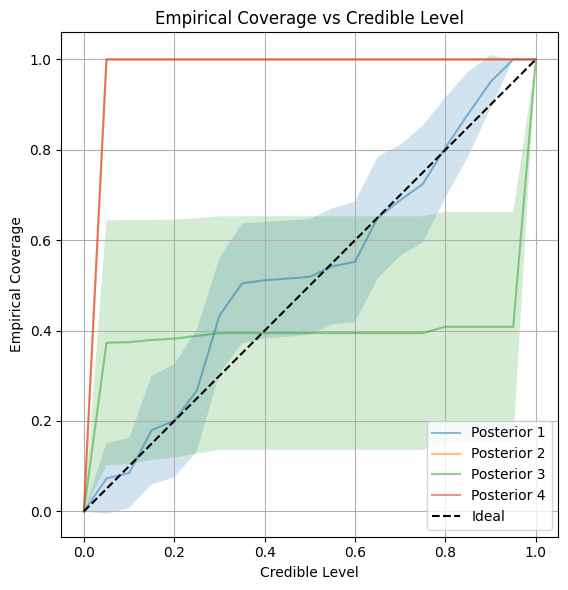

In [9]:
import os
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

# Dictionary to save all data
tarp_data = {}
for i in range(4):
    mean = np.mean(ecp_boots[i], axis=0)
    std = np.std(ecp_boots[i], axis=0)
    ax.plot(alphas[i], mean, label=f"Posterior {i+1}", alpha=0.5)
    ax.fill_between(alphas[i], mean - 1*std, mean + 1*std, alpha=0.2)

    # Save data for each model
    tarp_data[f'posterior_{i+1}_ecp_mean'] = mean
    tarp_data[f'posterior_{i+1}_ecp_std'] = std
    tarp_data[f'posterior_{i+1}_alpha'] = alpha


ax.plot([0, 1], [0, 1], 'k--', label="Ideal")
ax.set_xlabel("Credible Level")
ax.set_ylabel("Empirical Coverage")
ax.set_title("Empirical Coverage vs Credible Level")
ax.legend()
# Force square aspect ratio
ax.set_aspect('equal', adjustable='box')
ax.grid(True)
plt.tight_layout()
plt.savefig('lensing_tarp_coverage_all_posteriors.pdf')
plt.show()

# Save data

np.savez_compressed('./Lensing_tarp_coverage_data.npz', **tarp_data)
